In [39]:
import pandas as pd
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [3]:
file = open('./pickles/house_latlong.p','rb')
house_df = pickle.load(file)
real_estate_df = pickle.load(open('./pickles/real_estate_latlong.p','rb'))

In [62]:
#dropping NA values with lat long. 
house_df = house_df[~np.isnan(house_df.latitude)]
#redo this with the cosine(42) multiplication. 
house_df.loc[:,'e_long'] = house_df['longitude']*np.cos(np.radians(42))

#### Data Cleaning Notes:
Dropping following columns since they are Null/0 in more than 10% of the rows:  
- Alley
- PoolQC
- MiscFeature
- MiscVal (connected with MiscFeature)
- LowQualSF
- LandContour
- Electrical

Drop but potentially come back:   
- FireplaceQu
- MSZoning, MSSubClass
- MasVnrType, MasVnrArea
- LotFrontage

Drop since higly correlated:   
- Condition2 (same as condition1)
- Exterior2nd (same as Exterior1)
- ExterCond (similar to ExterQual)
- GarageCond (similear to GarageQual)

Drop ID/Address numbers:  
- MapRefNo
- PID
- Prop_Addr 

Drop due to linear dependence:   
- GrLivArea (sum of 1stflr, 2ndflr)
- TotalBsmtSF (sum of BsmtFinSF1, BsmtFinSF2, BsmtUnfSF)  

Booleanize columns:   
- Fence 

Feature Combining:  
- Bathrooms: Sum of all bathrooms
- 

#### Feature Engineering Notes
Reengineer OverallQual/Cond columns (linear regression on other material/quality columns)

In [230]:
#columns to drop:
drop_columns = ['Alley','PoolQC','MiscFeature','MiscVal',
                'FireplaceQu','MSSubClass','MSZoning',
                'Condition2','PID','MapRefNo','Prop_Addr',
                'MasVnrType','MasVnrArea','GrLivArea','TotalBsmtSF',
                'LowQualFinSF','ExterCond','Neighborhood','LotFrontage',
                'LotConfig','LotShape','LandContour','Exterior2nd',
                'GarageCond','Electrical','SaleType','SaleCondition']
#copied dataframe with dropped columns:
df = house_df.drop(drop_columns,axis = 1)

##feature relations:
#bathrooms
df['bathrooms'] = df['FullBath'] + df['BsmtFullBath'] + 0.5*(df['BsmtHalfBath'] + df['HalfBath'])
df = df.drop(['FullBath','BsmtFullBath','BsmtHalfBath','HalfBath'],axis = 1)
#Age
df['Age'] = df['YrSold'] - df['YearRemodAdd']
df['WasRemodeled'] = (df.YearRemodAdd != df.YearBuilt).astype(np.int64)
df = df.drop(['YrSold','YearRemodAdd','YearBuilt'],axis = 1)
#Fence
df.loc[:,'Fence'] = (~df.Fence.isna()).astype(np.int64)
#Basement
df = df.drop(['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'], axis = 1)
df['BsmtQual'][df['BsmtQual'].isna()] = 'TA'
#Garage
df['HasGarage'] = df.GarageArea.apply(lambda x: 1 if x > 0 else 0).astype(np.int64)
df = df.drop([col for col in list(df.columns) if 'Garage' in col],axis = 1)

#Dummify
df = pd.get_dummies(df,drop_first=True)

#Last nulls set to 0
df[np.isnan(df)] = 0 

#Log of the SalePrice
#df.loc[:,'SalePrice'] = np.log(df['SalePrice'])

<ipython-input-230-452dfdffe9e2>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BsmtQual'][df['BsmtQual'].isna()] = 'TA'


In [231]:
KNR = KNeighborsRegressor()

x_train, x_test, y_train, y_test = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice'], test_size = .2,
                                                    random_state = 42)
params = {'n_neighbors':range(10,100)}
gcv_knr = GridSearchCV(KNR,param_grid = params)

gcv_knr.fit(x_train[['latitude','e_long']],y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [234]:
gcv_knr.score(x_train[['latitude','e_long']],y_train), gcv_knr.score(x_test[['latitude','e_long']],y_test)

(0.761270677624868, 0.6697964124020531)

In [235]:
KNR = KNeighborsRegressor()



x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(df.drop('SalePrice', axis = 1),
                                                    df['SalePrice']/(df['1stFlrSF']+df['2ndFlrSF']),
                                                    test_size = .2,
                                                    random_state = 42)

params = {'n_neighbors':range(10,100)}
gcv_knr_price_foot = GridSearchCV(KNR,param_grid = params)

gcv_knr_price_foot.fit(x_train_pf[['latitude','e_long']],y_train_pf)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(10, 100)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [239]:
gcv_knr_price_foot.score(x_train_pf[['latitude','e_long']],y_train_pf), gcv_knr_price_foot.score(x_test_pf[['latitude','e_long']],y_test_pf)

(0.48172048026200376, 0.36261144092371234)

In [280]:
lam = 1
x_train.loc[:,'residuals'] = y_train - lam*gcv_knr.predict(x_train[['latitude','e_long']])
x_test.loc[:,'residuals'] = y_test - lam*gcv_knr.predict(x_test[['latitude','e_long']])

x_train = x_train.drop(['latitude','longitude','e_long'],axis = 1)
x_test = x_test.drop(['latitude','longitude','e_long'], axis =1)

KeyError: "None of [Index(['latitude', 'e_long'], dtype='object')] are in the [columns]"

In [277]:
lm_ridge = Ridge(normalize= True)
lmr_gcv = GridSearchCV(lm_ridge,param_grid={'alpha':[0,0.1,1,5,10]})
lmr_gcv.fit(x_train.drop('residuals', axis =1), x_train['residuals'])

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0, 0.1, 1, 5, 10]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [278]:
lmr_gcv.score(x_train.drop('residuals', axis =1), x_train['residuals']), lmr_gcv.score(x_test.drop('residuals', axis =1), x_test['residuals'])

(0.8249347747329395, 0.7683984248507512)

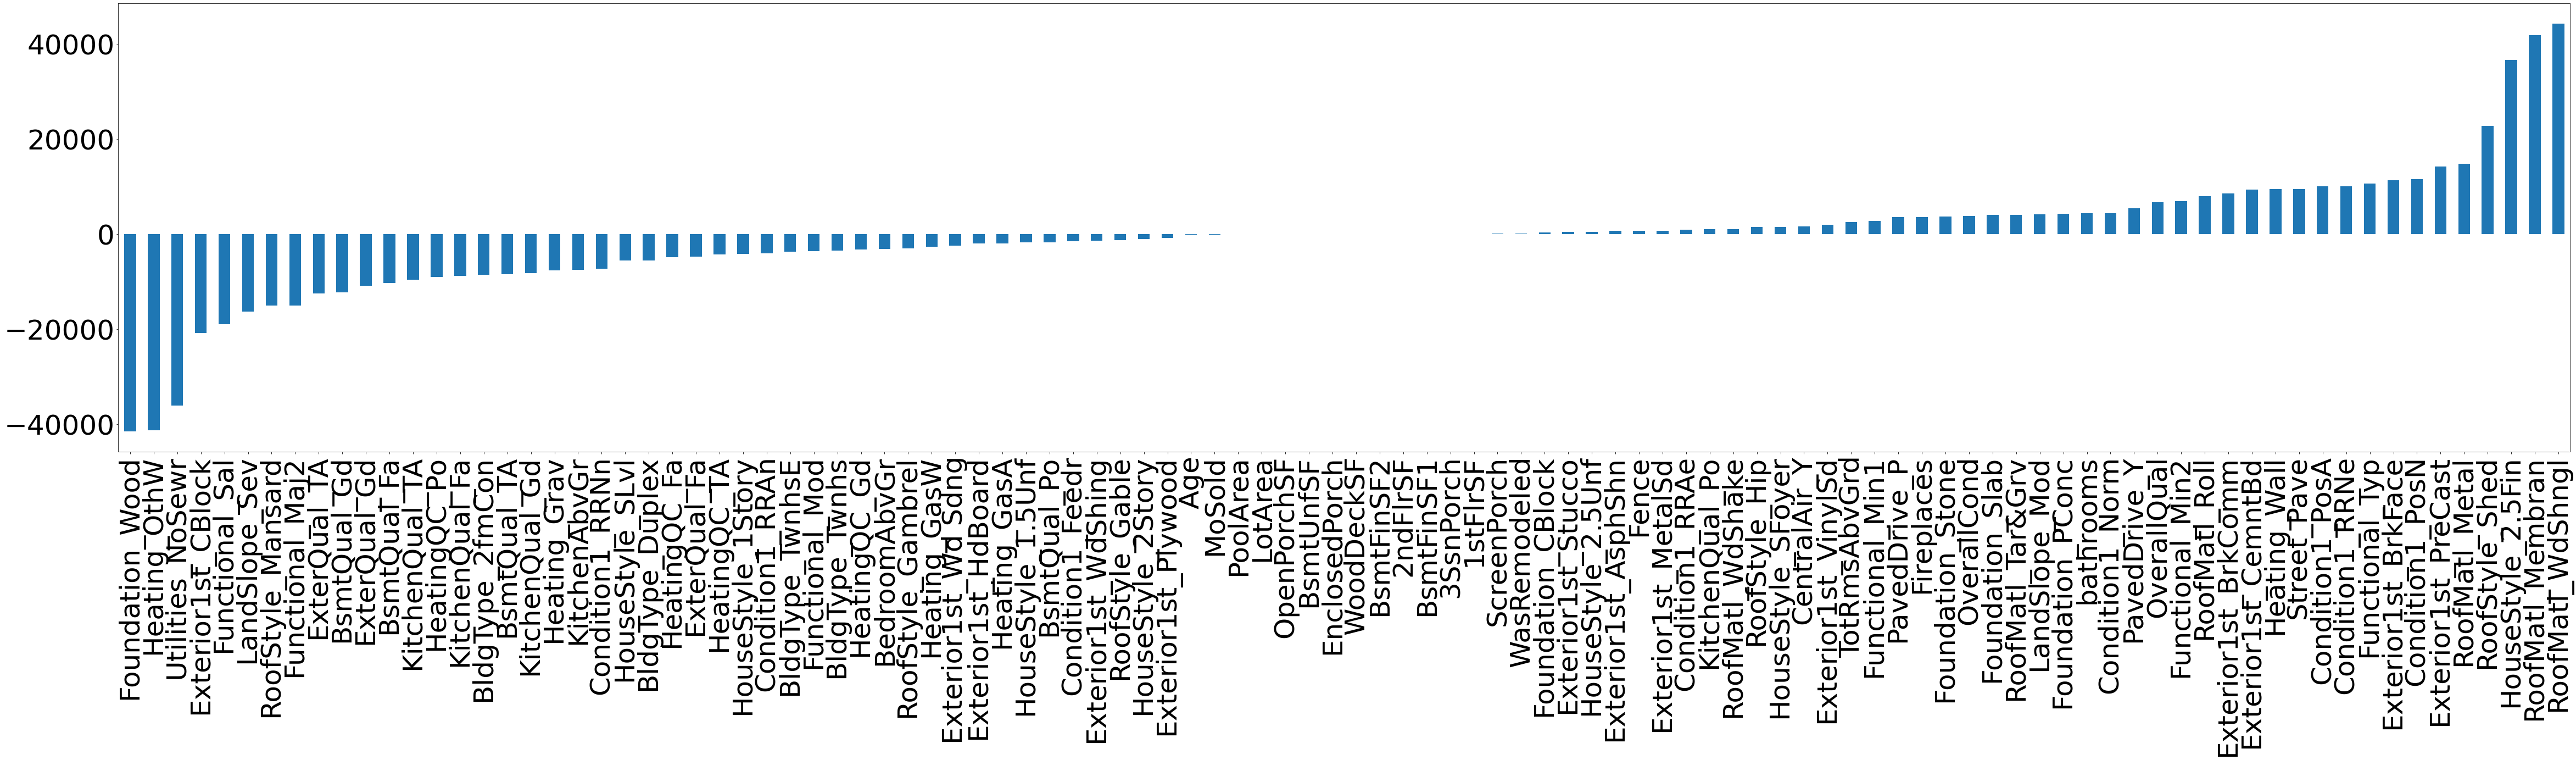

In [279]:
pd.Series(dict(zip(x_train.drop('residuals', axis =1).columns, lmr_gcv.best_estimator_.coef_))).sort_values().plot.bar(rot = 90, figsize = (80,15),fontsize = 50)